In [55]:
import math
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

In [56]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

def Sprott(xi, t):
    (x,y,z) = xi
    return ( y,-x - np.sign(z)*y, y**2 - np.exp(-x**2))

def SprottP(xi, t, d):
    (x,y,z) = xi
    return ( y, -x - np.sign(z)*y, y**2 - d*np.exp(-x**2))

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d 

In [97]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

# embedd with tuple of all variables as if each were a single variable
def delayEmbedUnitary(Xin, Yin, eD, eI):
    # eD - embedding dimension, eI - embedding Interval
    n = Xin.shape[0]
    
    if Xin.ndim == 1: # make sure flattened arrays are given 1 width dimension
        p = 1
        Xin = Xin.reshape((n,1))
    else:
        p = Xin.shape[1]
        
    Xout = np.zeros((n-eD*eI, p*(1+eD)))
    for ed in range(eD+1):
        Xout[:,ed*p:(ed+1)*p] = Xin[ed*eI:n-(eD-ed)*eI]
    Yout = Yin[eD*eI:]
    return (Xout, Yout)

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?

def createNearestNeighborGraph(X, nNeighbors):
    n = X.shape[0]
    denseAdjacencyMatrix = np.ones((n, n)) * np.inf
    
    for i in range(n):
        neighborIndices = nearestNeighbors(X[i,:], X, nNeighbors)
        
        for j in neighborIndices:
            denseAdjacencyMatrix[i,j] = la.norm(X[i,:] - X[j,:])
            
    return denseAdjacencyMatrix

def createLaplacianMatrix(X, T, nNeighbors):
    n = X.shape[0]
    
    W = np.zeros((n,n)) # Weights, positif at neighbors, 0 else, uses heat kernel
    for i in range(n):
        neighborIndices = nearestNeighbors(X[i,:], X, nNeighbors)
        for j in neighborIndices:
            diff = X[i]-X[j]
            W[i,j] = np.exp(-1*la.norm(diff)**2/(2*T**2)) # heat kernel
            
    D = np.sum(W,axis=1) * np.identity(n)# degree matrix(degree of each vertex)
    L = W - D # Laplacian Matrix
    
    Dinv = np.sum(W,axis=1) ** (-1/2) * np.identity(n)
    L = Dinv @ L @ Dinv # normalize that shit
    
    return L, D

# More Efficient Version I think, could be wrong. This is more
# for Diffusion Maps than Laplacian Eigenmaps
def diffusionMap(X, t, a):
    n = X.shape[0]
    
    diffMatrix = np.zeros((n,n)) # Weights, positif at neighbors, 0 else, uses heat kernel
    """
    for i in range(n):
        for j in range(i,n):
            diff = X[i]-X[j]
            heat = np.exp( -1 * la.norm(diff)**2 / a ) # heat kernel
            heatMatrix[i,j] = heat
            heatMatrix[j,i] = heat
    """
    for i in range(n):
        for j in range(i,n):
            diff = la.norm(X[i,:]-X[j,:])
            diffMatrix[i,j] = diff
            diffMatrix[j,i] = diff
            
    if a == 0:
        a = np.mean(np.sort(diffMatrix,axis=0)[:,5] ** 2)
        print("We computed alpha to be ",a)
            
    heatMatrix = np.exp( -1 * (diffMatrix**2) / a )
    
    transitionMatrix = la.inv(np.diag((np.sum(heatMatrix, axis=1)))) @ heatMatrix
    
    eigenValues, eigenVectors = la.eig(transitionMatrix)
    
    diffusionMap = (np.diag(eigenValues ** t) @ eigenVectors.T).T
    
    return diffusionMap


In [126]:
end = 2**6
tlen = 2 ** 11
transient = 50
print("Stepsize = {st}".format(st=end/tlen))
trainToTest = 0.5 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1
# t0 = np.array([0.5])
t0 = np.array([0,5,15])
# t0 = np.ones(dim) * 0.3333 #  * 1 # np.ones(dim) * 0.3333 # np.zeros(dim)
t0[0] += 0.1

Stepsize = 0.03125


In [135]:
# Lorenz
rho = lambda t : 22 + 12*np.sin(1.687/7*2*np.pi*t/tlen)# + 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1))  # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10.0 # + np.cos(1/2*2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
Xr = standardize(states)[transient:,0,None]


# Lorenz 96
# Xr = standardize(odeint(Lorenz96, t0,t))[transient:]


In [136]:
""" UPDATE DRIVERS HERE """
digiDrivers = [rho]

gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp

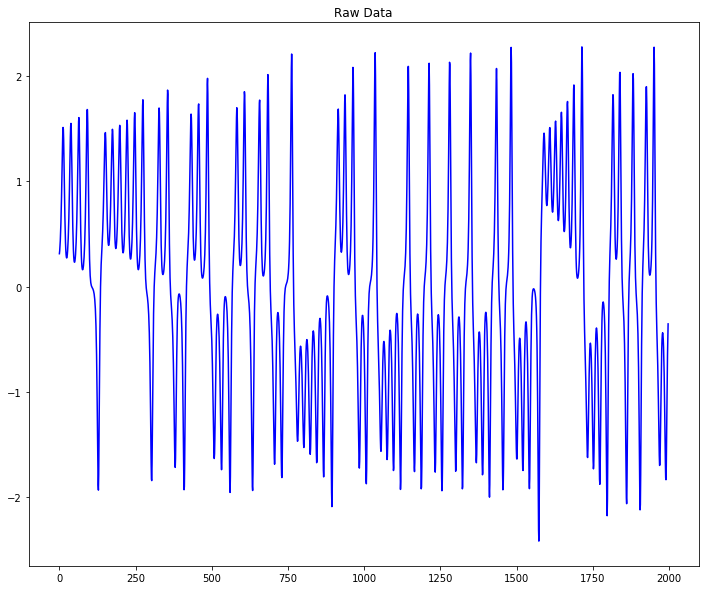

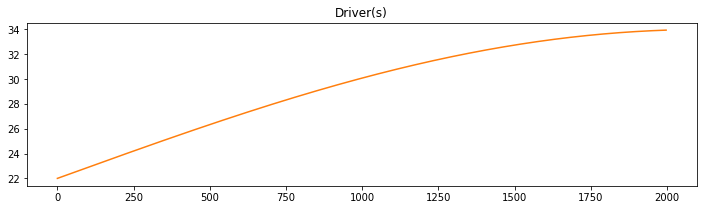

In [137]:
fig2 = plt.figure(2,figsize=(12,10))
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
ax2.set_title("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver(s)")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
        
plt.show()

In [138]:
# False Nearest Neighbors Test
"""
# Unitary Embedding Testing

l = 6
st = 3

# figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
figFNN, axFNN = plt.subplots(dim, figsize=(16, 6*dim))
# figFNN = plt.figure(figsize=(12, 8))
# axFNN = figFNN.add_subplot()

for d in range(dim):
    lyapExps = np.zeros(l+1)
    for s in range(1, st+1, 1):
        for i in range(l+1):
            Y, _ = delayEmbed(Xr[:,d,None], Xr[:,d,None], [i],s) # individual axis version
            # Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
            # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
            lyapExps[i] = lyapunovExp(Y)
            
        axFNN[d].plot(range(l+1), lyapExps, label="{e}".format(e=s))

    axFNN[d].legend()
    axFNN[d].set_xlabel("Embedding Dimension")
    # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
    axFNN[d].set_ylabel("Lyapunov Exponent")
    
plt.show()
"""

'\n# Unitary Embedding Testing\n\nl = 6\nst = 3\n\n# figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))\nfigFNN, axFNN = plt.subplots(dim, figsize=(16, 6*dim))\n# figFNN = plt.figure(figsize=(12, 8))\n# axFNN = figFNN.add_subplot()\n\nfor d in range(dim):\n    lyapExps = np.zeros(l+1)\n    for s in range(1, st+1, 1):\n        for i in range(l+1):\n            Y, _ = delayEmbed(Xr[:,d,None], Xr[:,d,None], [i],s) # individual axis version\n            # Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)\n            # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)\n            lyapExps[i] = lyapunovExp(Y)\n            \n        axFNN[d].plot(range(l+1), lyapExps, label="{e}".format(e=s))\n\n    axFNN[d].legend()\n    axFNN[d].set_xlabel("Embedding Dimension")\n    # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))\n    axFNN[d].set_ylabel("Lyapunov Exponent")\n    \nplt.show()\n'

In [139]:
X, _ = delayEmbed(Xr, Xr, [10],1)

In [144]:
# nnGraph = createNearestNeighborGraph(Xr, 4)
"""
laplacian, D = createLaplacianMatrix(X, 10**3,10)
laplacianEigenValues, laplacianEigenVectors = la.eigh(-laplacian)

laplacianEigenMap = laplacianEigenVectors @ (D ** (1/2))
"""

# if first DM coord is a flat line, a is too high. If the DM coords are spiky,
# then a is too low. Very high a values correspond to near equal probability
# of moving from one node to any other, low a values correspond to a very
# local kernel. If you set a = 0, then we compute a for you per Berry's recommendation
DM = diffusionMap(X, 50, 0)
print(DM)

We computed alpha to be  27.40311566758788
[[ 2.24280652e-02+0.j -1.07403599e-18+0.j  1.12363751e-47+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 2.24280652e-02+0.j -1.21771670e-18+0.j  1.28972653e-47+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 2.24280652e-02+0.j -1.36204322e-18+0.j  1.39678962e-47+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 ...
 [ 2.24280652e-02+0.j  1.83413192e-18+0.j  5.08549932e-48+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 2.24280652e-02+0.j  1.77719514e-18+0.j  1.17389102e-47+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 2.24280652e-02+0.j  1.68089948e-18+0.j  1.70593988e-47+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]]


b:\python\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


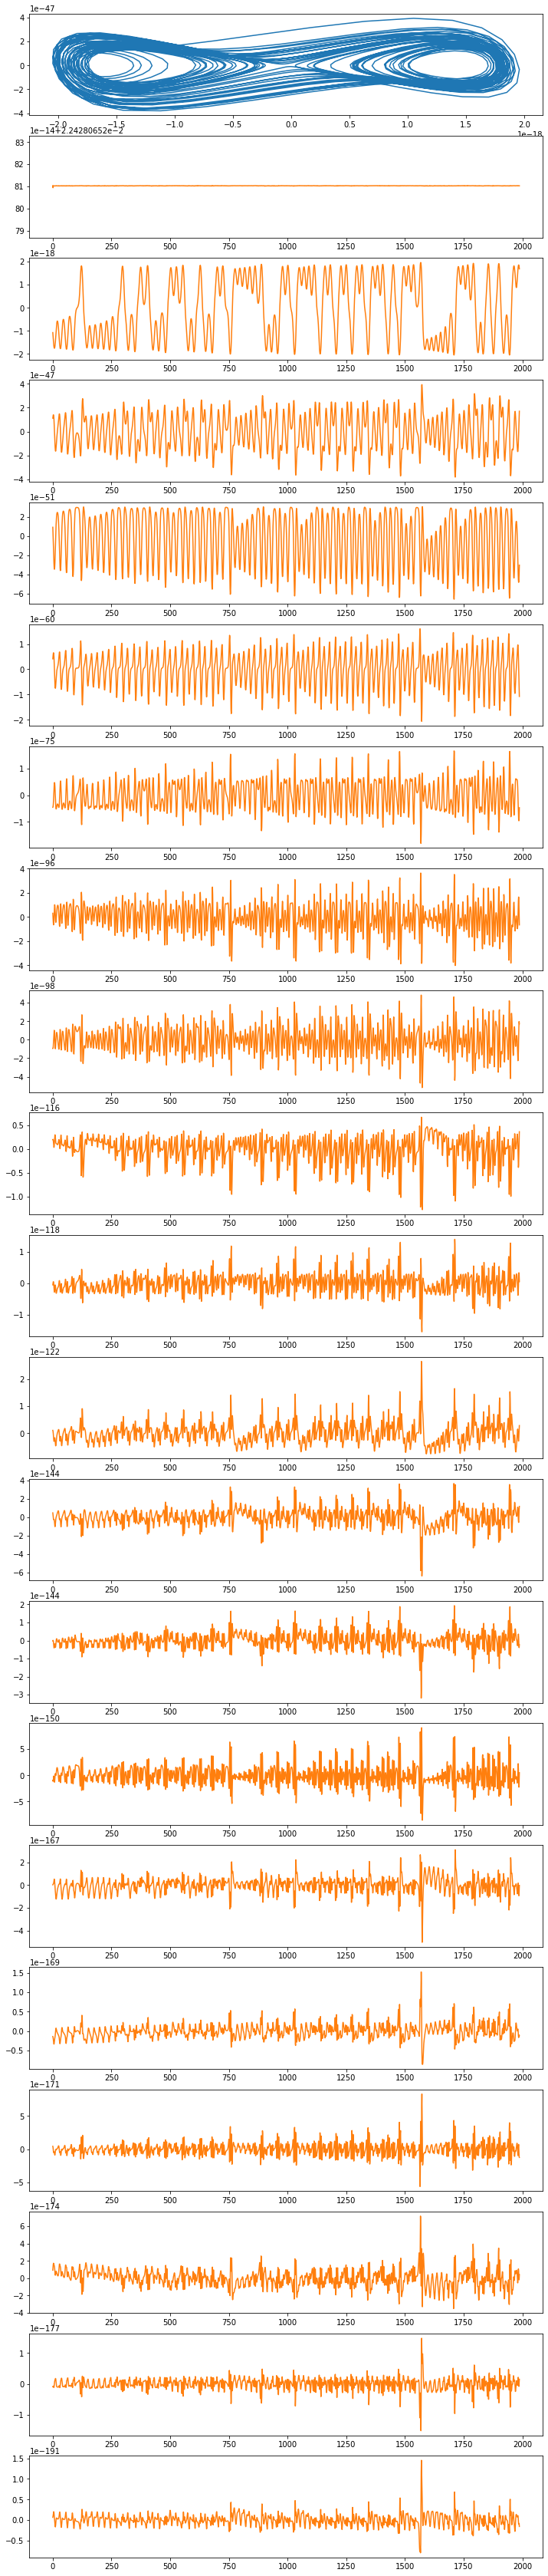

In [145]:
# figNNG, axNNG = plt.subplots(2,figsize=(12,16))

# print(laplacianEigenValues)
# print(laplacianEigenVectors)

# print("Error is ", np.sum(abs(laplacian - lapacianEigenVector @ (lapacianEigenValues*np.identity(laplacian.shape[0])) @ lapacianEigenVector.T))/np.sum(abs(laplacian)))

# plot = axNNG[0].imshow(laplacian)
# plt.colorbar(plot)

# axNNG[1].plot(DM[:,0],DM[:,1])

m = 20 # dimensionality reduction
# figNNG3d = plt.figure(figsize=(12,12))
# axNNG3d = figNNG3d.add_subplot(2,1,2,projection="3d")
# axNNG3d = figNNG3d.add_subplot(2,1,2)
# axNNG3d.plot(laplacianEigenMap[:,:10])
figDM, axDM = plt.subplots(m+1,figsize = (12,3*m+1))
axDM[0].plot(DM[:,1], DM[:,2])
for i in range(m):
    axDM[i+1].plot(DM[:,i], color="tab:orange")

plt.show()

In [ ]:
A = np.array([[1,-1,-1,0],
              [-1,3,-1,-1],
              [0,-1,2,-1],
              [0,-1,-1,2]])

eigibois, eigiguurls = la.eigh(A)

b:\python\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


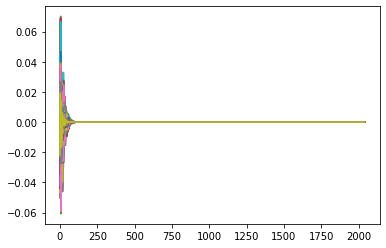

In [40]:
figDM, axDM = plt.subplots(1)

print()

axDM.plot(DM[:].T)
plt.show()

In [ ]:
B = np.fromfunction(lambda i,j:i-j,(100,100))

eigValuesB, eigVectorsB = la.eigh(B)

figLaplacian, axLaplacian = plt.subplots(3,figsize = (10,12))
axLaplacian[0].imshow(B)
axLaplacian[1].plot(eigVectorsB[:,:100] * eigValuesB[:100])
axLaplacian[2].plot(np.sum(eigVectorsB[:,:100] * eigValuesB[:100],axis=1))

plt.show()
print(eigValuesB)